# Programa para cálculo de área do espelho d'água em reservatório e comparação entre duas datas distindas com uso de imagens Landsat-8/OLI:

Para dois conjuntos de imagens das bandas do Satélite Landsat8 sensor OLI Level-2, de duas datas distintas (baixadas do https://earthexplorer.usgs.gov) o programa inicialmente separa dados de arquivos e bandas de interesse. Posteriormente, é realizado o recorte da área de interesse que contem o reservatório de estudo com uso do software QGIS devido dificuldade encontrada em recortar o arquivo por linha de código. Com as bandas recortadas, é realizado o calculo de NDWI (Normalized Difference Water Index) para extrair a máscara de água em formato raster (GeoTIFF). Por fim, é calculado a área para cada uma das datas com base na máscara. Assim, foi possivel obter a variação percentual da área do espelho d'água entre as duas datas. 


Para funcionar o programa de forma correta, o usuario deve descompactar os arquivos baixados das cenas em suas respectivas 'pastas de entrada', conforme instruido durante o programa. 

## 1) Importando pacotes de ferramentas necessárias para o programa.

In [1]:
from osgeo import gdal,gdalconst,osr
from gdalconst import *
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sys
import shutil
gdal.UseExceptions()

## 2) Definindo funções do programa.

In [2]:
# Função que toma como argumento: 'lista' com nome de arquivos pré estabelecida pelo usuário, caminho do 'diretório' no qual se 
# encontram os arquivos da lista e caminho do 'diretório raiz' (dir_raiz) para retorno ao diretório raiz com função os.chdir()

def selecao(lista, diretorio, dir_raiz):
    os.chdir(diretorio) # Associa o caminho para a função ao diretório onde a lista de arquivos se encontra
    
    for x in lista:
        if x[-3:] != 'tif':
            os.remove(x) # Deleta os arquivos da lista cuja extensão é diferente de '.tif'
            
    lista_2 = os.listdir() # Define nova lista contendo apenas os nomes dos arquivos que restaram
    
    for x in lista_2:
        if x[-9:-4] != 'band3' and x[-9:-4] != 'band5':
            os.remove(x) # Deleta os arquivos da lista mantendo apenas os arquivos das bandas de interesse (bandas 3 e 5)
            
    lista_3 = os.listdir() # Define nova lista contendo apenas os nomes dos arquivos que restaram
    print(lista_3)
    
    os.chdir(dir_raiz) #Retorna o caminho para a função ao diretório raiz do programa

In [3]:
# Função para salvar arquivo GeoTIFF gerado por cálculo ou função estabelecida tomando como argumento: 'matriz de pixels' a qual
# se quer escrever e salvar os dados em arquivo '.tif', 'nome do arquivo' contendo caminho do diretório seguido do nome do
# arquivo e por fim dataset de referência, do qual serão extraidas informações espaciais, de projeção e sobre METADADOS  

def salvar_banda(matriz_de_pixels, nome_do_arquivo, dataset_de_referencia):
    linhas = dataset_de_referencia.RasterYSize
    colunas = dataset_de_referencia.RasterXSize
    bandas = 1 # Obetem METADADOS da imagem
    
    driver = gdal.GetDriverByName('GTiff') # Define DRIVE para criação de GeoTIFF
    
    data_type = dataset_de_referencia.GetRasterBand(1).DataType # Copia tipo de dado de banda já existente
    
    dataset_output = driver.Create(nome_do_arquivo, colunas, linhas, bandas, data_type) # Cria novo dataset para arquivo de saida
    
    dataset_output.SetGeoTransform(dataset_de_referencia.GetGeoTransform()) # Copia informação espacial da banda já existente
    
    dataset_output.SetProjection(dataset_de_referencia.GetProjectionRef()) # Copia informação de projeção da banda já existente

    dataset_output.GetRasterBand(1).WriteArray(matriz_de_pixels) # Escreve dados de saída na forma de matriz (array) da banda

    dataset_output.FlushCache() # Salva valores no arquivo de saída
    
    dataset_output = None # Fecha dataset de saída criado para liber a memória

In [4]:
# Função que calcula valor de NDWI dadas bandas do espectro VERDE e IV-Próximo e gera mascara de água para a cena onde a água
# é classificada com valor 1 e tudo que não é agua é classificado com valor 0, esta função toma como argumentos: a banda 3 (VERDE)
# e banda 5 (IV Próximo) do sensor Landsat-8/OLI, sendo estes argumentos inseridos na forma de string com o caminho completo até
# o arquivo, incluindo nome completo do arquivo, esta função tambpem precisa de 2 argumentos contendo o caminho com nome completo
# do 'arquivo NDWI' e 'arquivo Mascara' onde salvar tais arquivos.

def NDWI(green, nir, arquivo_ndwi, arquivo_mascara):
    try:
        dataset_green = gdal.Open(green, GA_ReadOnly)
        dataset_nir = gdal.Open(nir, GA_ReadOnly)
    except:
        print('Erro na abertura de algum dos arquivos') 
        
    if (dataset_green.GetProjectionRef() != dataset_nir.GetProjectionRef()):
        print('Sistemas de referência diferentes')
    elif (dataset_green.GetGeoTransform() != dataset_nir.GetGeoTransform()):
        print('Metadados espaciais diferentes')
    else:
        linhas = dataset_green.RasterYSize
        colunas = dataset_green.RasterXSize
        
        raster_green = dataset_green.GetRasterBand(1).ReadAsArray()
        raster_nir = dataset_nir.GetRasterBand(1).ReadAsArray()
    
        raster_ndwi = (raster_green - raster_nir) / (raster_green + raster_nir)
    
        raster_mascara = raster_ndwi
        raster_mascara[raster_mascara >= 0] = 1
        raster_mascara[raster_mascara < 0] = 0
                
        plt.figure(figsize=(10, 4))
        
        plt.subplot(121)
        plt.imshow(raster_ndwi)
        plt.title('Raster NDWI')
        
        plt.subplot(122)
        plt.imshow(raster_mascara)
        plt.title('Raster Máscara de água')
        
        plt.show()
        
    salvar_banda(raster_ndwi, arquivo_ndwi, dataset_green)
    salvar_banda(raster_mascara, arquivo_mascara, dataset_green)
    
    dataset_green = None
    dataset_nir = None

In [5]:
# Função que calcula a área da máscara de água, esta função mostra a contagem de pixels e área classificada como água, retornando
# para atribuição de variável o valor da área
def area_agua(mascara, pixel):
    try:
        dataset_mascara = gdal.Open(mascara, GA_ReadOnly)
    except:
        print('Erro na abertura do arquivo')
        
    raster_mascara = dataset_mascara.GetRasterBand(1).ReadAsArray()
    
    cont = np.count_nonzero(raster_mascara)
    
    area = cont * pixel
    
    print('Número de píxels:', cont)
    print('Área da máscara [m²]:', area)
    
    return area

In [6]:
# Função que calcula o percentual de variação entre dois valores atribuidos
def percentual_var(x, y):
    Δ = round((x-y) * 100 / x, 2)
    print('Δ% de Área:', Δ)

## 3) Criando caminhos para diretórios e arquivos necessários para o programa

In [7]:
# Criando strings de chamada para os diretórios
raiz = os.getcwd()
dir_tif = os.path.join(raiz, 'tif')
dir_tif_e = os.path.join(dir_tif, 'e')
dir_tif_s = os.path.join(dir_tif, 's')
dir_passado_e = os.path.join(dir_tif_e, 'passado')
dir_atual_e = os.path.join(dir_tif_e, 'atual')
dir_passado_s = os.path.join(dir_tif_s, 'passado')
dir_atual_s = os.path.join(dir_tif_s, 'atual')

# Criando strings de chamada para os arquivos
green_passado = os.path.join(dir_passado_e, 'cut_band3.tif')
nir_passado = os.path.join(dir_passado_e, 'cut_band5.tif')
green_atual = os.path.join(dir_atual_e, 'cut_band3.tif')
nir_atual = os.path.join(dir_atual_e, 'cut_band5.tif')
ndwi_passado = os.path.join(dir_passado_s, 'ndwi_passado.tif')
ndwi_atual = os.path.join(dir_atual_s, 'ndwi_atual.tif')
mascara_passado = os.path.join(dir_passado_s, 'mascara_passado.tif')
mascara_atual = os.path.join(dir_atual_s, 'mascara_atual.tif')

In [8]:
# Criando diretórios para o programa a partir das strings de chamada
os.makedirs(dir_tif, exist_ok=True)
os.makedirs(dir_tif_e, exist_ok=True)
os.makedirs(dir_tif_s, exist_ok=True)
os.makedirs(dir_passado_e, exist_ok=True)
os.makedirs(dir_atual_e, exist_ok=True)
os.makedirs(dir_passado_s, exist_ok=True)
os.makedirs(dir_atual_s, exist_ok=True)

In [9]:
print('\r''Diretórios', '\n''Raiz:', '\t\t\t', raiz,
      '\n''TIF:', '\t\t\t', dir_tif, '\n''TIF entrada:', '\t\t', dir_tif_e,
      '\n''Passado entrada:', '\t', dir_passado_e, '\n''Atual entrada:', '\t\t', dir_atual_e,
      '\n''TIF saida:', '\t\t', dir_tif_s,
      '\n''Passado saida:', '\t\t', dir_passado_s, '\n''Atual saida:', '\t\t', dir_atual_s)

Diretórios 
Raiz: 			 C:\Users\Victor\OneDrive - inpe.br\base_dados\inpe\ser347_prog\trabalho 
TIF: 			 C:\Users\Victor\OneDrive - inpe.br\base_dados\inpe\ser347_prog\trabalho\tif 
TIF entrada: 		 C:\Users\Victor\OneDrive - inpe.br\base_dados\inpe\ser347_prog\trabalho\tif\e 
Passado entrada: 	 C:\Users\Victor\OneDrive - inpe.br\base_dados\inpe\ser347_prog\trabalho\tif\e\passado 
Atual entrada: 		 C:\Users\Victor\OneDrive - inpe.br\base_dados\inpe\ser347_prog\trabalho\tif\e\atual 
TIF saida: 		 C:\Users\Victor\OneDrive - inpe.br\base_dados\inpe\ser347_prog\trabalho\tif\s 
Passado saida: 		 C:\Users\Victor\OneDrive - inpe.br\base_dados\inpe\ser347_prog\trabalho\tif\s\passado 
Atual saida: 		 C:\Users\Victor\OneDrive - inpe.br\base_dados\inpe\ser347_prog\trabalho\tif\s\atual


## 4)  Rodando funções criadas sobre os dados:
### 4.1) Organizando dados

Após criação dos diretórios do programa o usuário deve descompactar os arquivos obtidos do site EarthExplorer citado anteriormente nos diretórios 'Seca entrada' e 'Atual entrada' respectivamente.

In [10]:
# Criando lista de arquivos dentro dosdiretórios de entrada
lista_passado_e = os.listdir(dir_passado_e)
lista_atual_e = os.listdir(dir_atual_e)

In [11]:
# Aplicando a função 'Seleção' sobre a lista de entrada de data da seca 
selecao(lista_passado_e, dir_passado_e, raiz)

['cut_band3.tif', 'cut_band5.tif', 'LC08_L1TP_219076_20150110_20170415_01_T1_sr_band3.tif', 'LC08_L1TP_219076_20150110_20170415_01_T1_sr_band5.tif']


In [12]:
# Aplicando a função 'Seleção' sobre a lista de entrada de data atual
selecao(lista_atual_e, dir_atual_e, raiz)

['cut_band3.tif', 'cut_band5.tif', 'LC08_L1TP_219076_20180510_20180517_01_T1_sr_band3.tif', 'LC08_L1TP_219076_20180510_20180517_01_T1_sr_band5.tif']


In [13]:
# Criando nova lista de arquivos dentro dos diretórios de entrada
lista_passado_e = os.listdir(dir_passado_e)
lista_atual_e = os.listdir(dir_atual_e)

In [14]:
# Arquivos de entrada de interesse para data de seca
lista_passado_e

['cut_band3.tif',
 'cut_band5.tif',
 'LC08_L1TP_219076_20150110_20170415_01_T1_sr_band3.tif',
 'LC08_L1TP_219076_20150110_20170415_01_T1_sr_band5.tif']

In [15]:
# Arquivos de entrada de interesse para data atual
lista_atual_e

['cut_band3.tif',
 'cut_band5.tif',
 'LC08_L1TP_219076_20180510_20180517_01_T1_sr_band3.tif',
 'LC08_L1TP_219076_20180510_20180517_01_T1_sr_band5.tif']

Com os arquivos originais para  as bandas de interesse separados é extraido da cena área de interesse (de conhecimento do usuário) para estudo com uso de software GIS da escolha do usuário, à partir dos rasters, para as duas datas, recortados e descarregados nos diretórios 'Seca entrada' e 'Atual entrada' respectivamente o programa segue com a criação dos rasters NDWI e máscara de água.

Como exemplo os rasters foram recortados usando-se software QGIS com uso de cordendadas de x e  y, mínimos e máximos, conhecidos pelos autores para a área de interesse.

### 4.2) Criando rasters NDWI e máscara de água

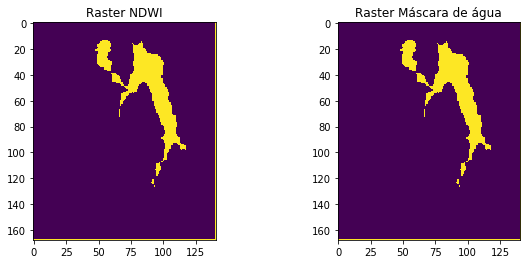

In [16]:
# Aplicando função NDWI para data de seca, onde é mostrado os dois GeoTIFF criados
NDWI(green_passado, nir_passado, ndwi_passado, mascara_passado)

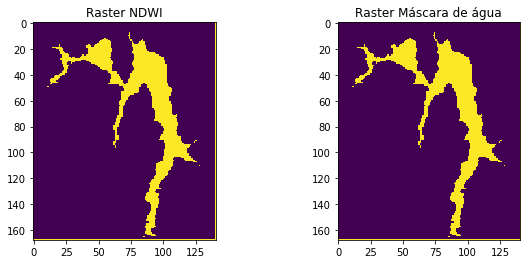

In [17]:
# Aplicando função NDWI para data atual, onde é mostrado os dois GeoTIFF criados
NDWI(green_atual, nir_atual, ndwi_atual, mascara_atual)

In [18]:
# Criando lista de arquivos dentro dos diretórios de saida
lista_passado_s = os.listdir(dir_passado_s)
lista_atual_s = os.listdir(dir_atual_s)

In [19]:
# Saida de produtos gerados para a data de seca
lista_passado_s

['mascara_passado.tif', 'ndwi_passado.tif', 'Thumbs.db']

In [20]:
# Saida de produtos gerados para a data atual
lista_atual_s

['mascara_atual.tif', 'ndwi_atual.tif', 'Thumbs.db']

### 4.3) Calculando área e percentual de variação de área

In [21]:
# Resolução espacial do pixel Landsat-8/OLI
res_landsat8 = 30
pixel_landsat8 = res_landsat8 ** 2

In [22]:
# Aplicando a função de cálculo da área da mascara de água para data de seca
area_passado = area_agua(mascara_passado, pixel_landsat8)

Número de píxels: 1918
Área da máscara [m²]: 1726200


In [23]:
# Aplicando a função de cálculo da área da mascara de água para data atual
area_atual = area_agua(mascara_atual, pixel_landsat8)

Número de píxels: 3244
Área da máscara [m²]: 2919600


In [24]:
# Aplicando a função de calculo do percentual de variação entre data atual e data atual
percentual_var(area_atual, area_passado)

Δ% de Área: 40.88
